In [18]:
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine

from src.utils.x_builder import build_boards_from_moves
from src.utils.utils import transform_dataset, build_symbol_list, boards_to_games_dict, build_hex_adjacency, build_graphs

import numpy as np
from sklearn.model_selection import train_test_split
from time import time

epochs = 15
clauses = 5000
T = 3250
s = 1.15
depth = 2
hv_bits = 1
hv_size = 1
msg_bits = 32
msg_size = 512
board_size = 7
n_board = board_size ** 2

print("Loading dataset...")
dataset = np.load("dataset/hex_7x7_100000.npz")
moves = dataset["moves"]
lengths = dataset["lengths"]
y_ds = dataset["winners"]
x_ds = build_boards_from_moves(moves, lengths, offset=0)

print("Final X shape:", x_ds.shape)

print("Pre-processing training and test dataset")
# Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x_ds, y_ds, test_size=0.2, random_state=42
)
game = 19999
print(X_train[game])

#print("Transforming dataset")
X_train = transform_dataset(X_train)
X_test = transform_dataset(X_test)
#print(f"Transformed dataset to {X_test[game]}")
print(f"Winner label: {y_train[game]}")

Loading dataset...
Final X shape: (100000, 7, 7)
Pre-processing training and test dataset
[[1 2 0 1 0 0 1]
 [2 1 1 1 0 1 2]
 [2 1 0 1 2 2 2]
 [2 1 2 0 1 1 2]
 [2 2 1 0 0 2 1]
 [1 1 0 2 2 1 2]
 [2 2 2 1 0 0 1]]
Winner label: 1


In [19]:


y_train = y_train.astype(np.uint32)
y_test = y_test.astype(np.uint32)

train_graph_length = X_train.shape[0]
test_graph_length = X_test.shape[0]
    

print("Converting board to game disctionaries")
train_games = boards_to_games_dict(X_train, board_size)
test_games = boards_to_games_dict(X_test, board_size)

print("Creating nodes and edges")
edges = build_hex_adjacency(board_size)

print("Creating symbols")
symbols = build_symbol_list(board_size)
edge_symbols = ["Plain", "Player 1", "Player 2"]
symbols.extend(edge_symbols)
hv_size = len(symbols)
graphs_train = build_graphs("Train", X=X_train, games=train_games, symbols=symbols, edges=edges, board_size=board_size,hv_size=hv_size, hv_bits=hv_bits)
graphs_test = build_graphs("Test", graphs_train, X_test, test_games, symbols, edges, board_size, hv_size, hv_bits)

tm = MultiClassGraphTsetlinMachine(
    clauses,
    T,
    s,
    depth=depth,
    message_size=msg_size,
    message_bits=msg_bits,
    grid=(16*13,1,1),
    block=(128,1,1),
    #double_hashing=True,
    #one_hot_encoding=True
)

train_acc = []
test_acc = []
epoch_list = []
epoch = 0
print("Starting training...")

for i in range(epochs):
    epoch += 1

    start_training = time()
    tm.fit(graphs_train, y_train, epochs=1, incremental=True)
    stop_training = time()
    training_time = stop_training - start_training

    start_testing = time()
    result_test = 100.0 * (tm.predict(graphs_test) == y_test).mean()
    stop_testing = time()
    inference_time = stop_testing - start_testing

    result_train = 100.0 * (tm.predict(graphs_train) == y_train).mean()

    train_acc.append(result_train)
    test_acc.append(result_test)
    epoch_list.append(epoch)

    print(
        f"Epoch: {epoch}, "
        f"Train acc: {result_train:.2f}%, "
        f"Test acc: {result_test:.2f}%, "
        f"Training time: {training_time:.2f}s, "
        f"Inference time: {inference_time:.2f}s"
    )



Converting board to game disctionaries
Creating nodes and edges
Creating symbols
Train has 118 symbols
Preparing node configuration for Train
Preparing edge configuration for Train
Adding Train node properties
Test has 118 symbols
Preparing node configuration for Test
Preparing edge configuration for Test
Adding Test node properties
Initialization of sparse structure.
Starting training...
Epoch: 1, Train acc: 65.72%, Test acc: 65.87%, Training time: 61.81s, Inference time: 8.90s
Epoch: 2, Train acc: 79.73%, Test acc: 79.50%, Training time: 53.69s, Inference time: 8.79s
Epoch: 3, Train acc: 85.11%, Test acc: 84.94%, Training time: 52.53s, Inference time: 8.79s
Epoch: 4, Train acc: 87.73%, Test acc: 87.19%, Training time: 51.39s, Inference time: 8.63s
Epoch: 5, Train acc: 87.58%, Test acc: 87.38%, Training time: 49.61s, Inference time: 8.52s
Epoch: 6, Train acc: 91.54%, Test acc: 91.22%, Training time: 49.59s, Inference time: 8.71s
Epoch: 7, Train acc: 87.89%, Test acc: 87.41%, Training 

KeyboardInterrupt: 


=== Interpretability analysis on one test game ===
[[0 1 2 1 1 2 2]
 [1 2 2 0 2 1 1]
 [1 2 2 1 2 0 2]
 [1 1 2 2 1 1 0]
 [0 2 0 1 1 2 1]
 [2 2 1 2 2 1 1]
 [0 1 1 1 2 2 2]]
Predicted winner (class): 1
Actual winner:  1
Positive evidence heatmap:
 [[17.  6. 30.  9.  6. 37. 37.]
 [19. 42. 33.  9. 34.  7. 15.]
 [25. 33. 38.  4. 36.  7.  9.]
 [32.  3. 35. 34. 19. 21. 12.]
 [ 5. 37.  9.  0. 34.  3. 31.]
 [35. 26. 39.  6. 47. 38. 27.]
 [ 7. 27. 26.  5. 37. 26. 30.]]
Negative (negated) evidence heatmap:
 [[1300. 1360. 1301. 1278. 1273. 1287. 1329.]
 [1274. 1325. 1230. 1338. 1302. 1336. 1309.]
 [1262. 1321. 1303. 1341. 1312. 1314. 1355.]
 [1299. 1316. 1292. 1299. 1319. 1282. 1360.]
 [1286. 1307. 1326. 1320. 1322. 1332. 1309.]
 [1285. 1291. 1319. 1256. 1289. 1323. 1295.]
 [1340. 1318. 1290. 1365. 1303. 1377. 1356.]]
Number of active clauses for this game: 1811


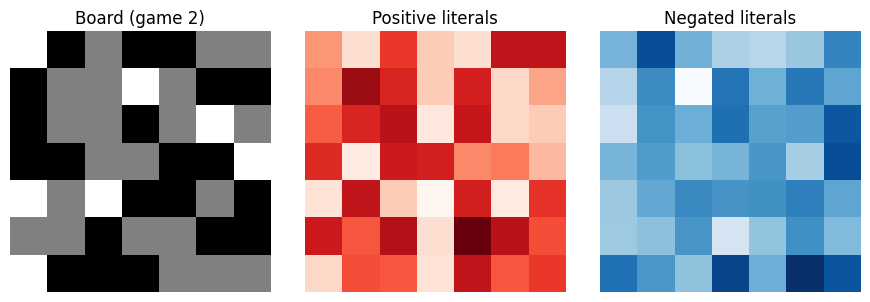

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def parse_cell_symbol(sym_name: str):
    if sym_name.startswith("Placement_"):
        _, i, j = sym_name.split("_")
        return int(i), int(j)

    if sym_name.startswith("Connected_"):
        _, i, j = sym_name.split("_")
        return int(i), int(j)
    return None


def explain_hex_game(game_idx, graphs, tm, symbols, board_size: int):

    # 1) Clause–symbol matrix (literals)
    symbol_hv = graphs.hypervectors
    clause_literals = tm.get_clause_literals(symbol_hv)  # (n_clauses, 2*n_symbols)
    n_symbols = symbol_hv.shape[0]

    # 2) Nodewise clause activations for all graphs
    clause_node_output, class_sum = tm.transform_nodewise(graphs)
    # clause_node_output: (n_graphs, n_clauses, max_nodes)

    clause_node = clause_node_output[game_idx]          # (n_clauses, n_nodes)
    pred_class = int(np.argmax(class_sum[game_idx]))    # predicted winner for this game

    # 3) Restrict to clauses of the predicted class
    n_total_clauses = tm.number_of_clauses
    n_outputs = tm.number_of_outputs
    clauses_per_class = n_total_clauses // n_outputs

    class_start = pred_class * clauses_per_class
    class_end = (pred_class + 1) * clauses_per_class

    # Clauses that fired on at least one node in THIS game
    firing = np.where(clause_node.sum(axis=1) > 0)[0]
    active_clauses = firing[(firing >= class_start) & (firing < class_end)]

    # 4) Aggregate which symbols those active clauses actually use
    pos_part = clause_literals[active_clauses, :n_symbols]
    neg_part = clause_literals[active_clauses, n_symbols:]

    # For each symbol: how many active clauses include it
    pos_sym_scores = (pos_part > 0).sum(axis=0)
    neg_sym_scores = (neg_part > 0).sum(axis=0)

    # 5) Map symbol scores back to board coordinates
    board_pos = np.zeros((board_size, board_size), dtype=float)
    board_neg = np.zeros_like(board_pos)

    for s_id, sym in enumerate(symbols):
        parsed = parse_cell_symbol(sym)
        if parsed is None:
            continue
        i, j = parsed
        board_pos[i, j] += pos_sym_scores[s_id]
        board_neg[i, j] += neg_sym_scores[s_id]

    return pred_class, board_pos, board_neg, active_clauses

print("\n=== Interpretability analysis on one test game ===")
g_idx = 0  # choose which test game to inspect

pred_class, pos_map, neg_map, active_clauses = explain_hex_game(
    game_idx=g_idx,
    graphs=graphs_test,
    tm=tm,
    symbols=symbols,
    board_size=board_size,
)
print(X_test[g_idx])
print("Predicted winner (class):", pred_class)
print("Actual winner: ", y_test[g_idx])
print("Positive evidence heatmap:\n", pos_map)
print("Negative (negated) evidence heatmap:\n", neg_map)
print("Number of active clauses for this game:", len(active_clauses))
board = X_test[g_idx]  # shape (board_size, board_size)

# 0=empty, 1=Player1, 2=Player2
cmap_board = ListedColormap(["white", "black", "gray"])

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(board, cmap=cmap_board, vmin=0, vmax=2, interpolation="nearest")
axes[0].set_title(f"Board (game {g_idx})")
axes[0].axis("off")

axes[1].imshow(pos_map, cmap="Reds", interpolation="nearest")
axes[1].set_title("Positive literals")
axes[1].axis("off")

axes[2].imshow(neg_map, cmap="Blues", interpolation="nearest")
axes[2].set_title("Negated literals")
axes[2].axis("off")

plt.tight_layout()
plt.show()
